In [52]:
from collections import defaultdict
import glob
from itertools import groupby
import operator
import os
import re

import numpy as np
import pandas as pd
import pickle
import random
import sparse
#import tensorly as tl
#import tensorly.decomposition as decomp
import sktensor
import urllib3
#import wget

import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

import logging
logging.basicConfig(level=logging.DEBUG, 
                    format='%(msecs)d %(levelname)-8s [%(lineno)d] %(message)s')

if not os.path.exists('cp_orth.py'):
    wget.download('http://web.stanford.edu/~vsharan/cp_orth.py')
from cp_orth import orth_als

47 DEBUG    [211] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Populating the interactive namespace from numpy and matplotlib


/home/makrai/tool/python/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['exp', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def mazsola_reader():
    pickle_path = '/mnt/store/home/makrai/project/verb-tensor/mazsola.pkl'
    if os.path.exists(pickle_path):
        logging.info('Loading mazsola dict from {}'.format(pickle_path))
        return pickle.load(open(pickle_path, mode='rb'))
    logging.info('Reading mazsola...'.format(pickle_path))
    path = '/mnt/permanent/Language/Hungarian/Dic/sass15-535k-igei-szerkezet/mazsola_adatbazis.txt'
    occurrence = defaultdict(int)#lambda: defaultdict(lambda: defaultdict(int)))
    margianls = [defaultdict(int) for _ in range(3)]
    with open(path) as infile:
        for i, line in enumerate(infile):
            if not i % 500000:
                logging.info('{:.0%}'.format(i/27970403))
            record = defaultdict(str)
            for token in line.strip().split():
                case_stem = re.split('@@', token)
                if len(case_stem) == 1:
                    continue
                try:
                    case, stem = case_stem
                except:
                    logging.warning(line.strip())
                record[case] = stem
            occurrence[record['NOM'], record['stem'], record['ACC']] += 1
            for i, mode in enumerate(['NOM', 'stem', 'ACC']):
                margianls[i][record[mode]] += 1            
    result = occurrence, margianls
    pickle.dump(result, open(pickle_path, mode='wb'))
    return result                

In [3]:
def get_tensor(middle_end='sktensor', cutoff=10):
    logging.info('Reweighting: log')
    verb_tensor_path = '/mnt/store/home/makrai/project/verb-tensor/{}/tensor_{}.pkl'.format(middle_end, cutoff)
    if os.path.exists(verb_tensor_path):
        logging.info('Loading tensor from {}'.format(verb_tensor_path))
        tensor, indices = pickle.load(open(verb_tensor_path, mode='rb'))
        logging.debug(tensor.shape)
        return tensor, indices
    occurrence, marginals = mazsola_reader()
    def get_index(freq_dict):
        items = sorted(filter(lambda item: item[1] >= cutoff, freq_dict.items()), key=operator.itemgetter(1), 
                       reverse=True)
        logging.debug(items[-3:])
        return dict([(w, i) for i, (w, f) in enumerate(items)])

    coords, data = ([], [], []), []
    indices = [get_index(fd) for fd in marginals]
    logging.info('Building tensor...')
    logging.info('  Pupulating lists...')
    for i, ((svo), freq) in enumerate(occurrence.items()):
        if not i % 2000000:
            logging.debug('    {:,}'.format(i))#'{} {}'.format(svo[1], freq))
        for i, word in enumerate(svo):
            if svo[i] not in indices[i]:
                break
        else:
            for i, word in enumerate(svo):
                coords[i].append(indices[i][svo[i]])
            data.append(np.log(freq))
    logging.info('  Creating array')
    shape = tuple(map(len, indices))
    logging.info(shape)
    if middle_end == 'tensorly':
        tensor = sparse.COO(coords, data, shape=shape)#, has_duplicates=False)
    elif middle_end == 'sktensor':
        tensor = sktensor.sptensor(coords, data, shape=shape)
    else:
        raise NotImplementedError
    pickle.dump((tensor, indices), open(verb_tensor_path, mode='wb'))
    logging.info(tensor)
    return tensor, indices

|cutoff|         shape         | d=2  | d=4  | d=5 | d=6 | d=7 | d=10|
|------|-----------------------|------|------|-----|-----|-----|-----|
|     1| 383 k, 110 k, 200 k   |      
|     2| 186 k,  60 k,  99 k   |
|     5|  97 k,  33 k,  50 k   |
|    10|  64 k,  23 k,  32 k   |
|    16|  49 k,  19 k,  24 k   |
|    32|  32 708 13 951 15 740 |14 min|
|    64|  21 033 10 294  9 874 | 6 min|
|   128|  13 093  7 345  6 116 | 2 min|
|------|-----------------------|------|------|-----|-----|-----|-----|
|   256|   7 957  5 054  3 740 | 2 min|
|   512|   4 598  3 269  2 183 | 1 min|
|  1024|   2 489  2 084  1 196 |  51 s|
|  2048|   1 251  1 293    579 |  27 s| 2 min|14 min|  
|  4096|     622    773    243 |  12 s| 1 min| 2 min|  m  |   s|15 min|
|  8192|     278    414    101 |     s|  55 s| 1 min|1 min|   s|4  min|
| 16384|      87    185     43 |     s|     s|  17 s| 29 s| 27s| 50 s |

10-es gyakorisági cutoffal a ginnyn még lefut, 5-össel már nem.

In [33]:
def decomp(cutoff, dim):
    logging.info((cutoff, dim))
    filen_base = '/mnt/store/home/makrai/project/verb-tensor/sktensor/decomp_{}_{}'.format(cutoff, dim)
    if os.path.isfile('{}.{}'.format(filen_base, 'pkl')):
        logging.info('File exists {} {}'.format(cutoff, dim))
        return
    vtensor, indices = get_tensor(cutoff=cutoff)
    try:
        result = orth_als(vtensor, dim)
        pickle.dump(result, open('{}.{}'.format(filen_base, 'pkl'), mode='wb'))
    except Exception as e:
        with open('{}.{}'.format(filen_base, 'err'), mode='w') as logfile:
            logging.error(e)
            logfile.write(e)

In [94]:
def show_expers(feature='exectimes'):
    mx = []
    for filen in glob.glob('/mnt/store/home/makrai/project/verb-tensor/sktensor/decomp_*.pkl'):
        _, cutoff, dim = os.path.splitext(filen)[0].split('_')
        ktensor, fit, n_iterations, exectimes = pickle.load(open(filen, mode='rb'))
        mx.append([int(cutoff), int(dim), sum(exectimes)/60])
    mx = np.array(mx)
    plt.scatter(np.array(mx).T[0], mx.T[1], c=mx.T[2])
    plt.colorbar()
    plt.xscale('log')

766 DEBUG    [507] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f00ed04f198>
766 DEBUG    [536] Using auto colorbar locator on colorbar
766 DEBUG    [537] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f00ed04f198>
767 DEBUG    [693] Setting pcolormesh
769 DEBUG    [2515] update_title_pos
772 DEBUG    [2157] vmin 6.902934678518222 vmax 23722.07986012423
772 DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
815 DEBUG    [2157] vmin 6.902934678518222 vmax 23722.07986012423
815 DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 60000

53 DEBUG    [2157] vmin 6.902934678518222 vmax 23722.07986012423
53 DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
54 DEBUG    [2157] vmin 6.902934678518222 vmax 23722.07986012423
55 DEBUG    [2212] ticklocs [0.2, 0.30000000000000004, 0.4, 0.5, 0.6000000000000001, 0.7000000000000001, 0.8, 0.9, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 200.0, 300.0, 400.0, 500.0, 600.0, 700.0, 800.0, 900.0, 2000.0, 3000.0, 4000.0, 5000.0, 6000.0, 7000.0, 8000.0, 9000.0, 20000.0, 30000.0, 40000.0, 50000.0, 60000.0, 70000.0, 80000.0, 90000.0, 200000.0, 300000.0, 400000.0, 500000.0, 600000.0, 700000.0, 800000.0, 900000.0, 2000000.0, 3000000.0, 4000000.0, 5000000.0, 6000000.0, 7000000.0, 8000000.0, 9000000.0]
57 DEBUG    [2157] vmin 6.902934678518222 vmax 23722.07986012423
57 DEBUG    [2212] ticklocs array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06])
59 DEBUG    [2157] vmin 6.902934678518222 

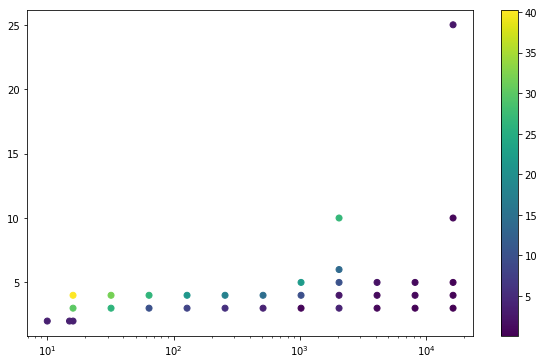

In [101]:
show_expers()

In [97]:
def rand_elem(list1):
    return list1[np.random.randint(0, len(list1))]

In [ ]:
while True:
    decomp(2**rand_elem(range(14, 3, -1)), 25)

796 INFO     [2] (256, 25)
798 INFO     [2] Reweighting: log
798 INFO     [5] Loading tensor from /mnt/store/home/makrai/project/verb-tensor/sktensor/tensor_256.pkl
52 DEBUG    [7] (7957, 5054, 3740)
463 DEBUG    [218] [  0] fit: 0.38376 | delta: 3.8e-01 | secs: 103.01304
489 DEBUG    [191] Zero norm, mode 0, count 0
506 DEBUG    [191] Zero norm, mode 1, count 0
520 DEBUG    [191] Zero norm, mode 2, count 0
313 DEBUG    [218] [  1] fit: 0.42198 | delta: 3.8e-02 | secs: 102.95067
341 DEBUG    [191] Zero norm, mode 0, count 0
361 DEBUG    [191] Zero norm, mode 1, count 0
375 DEBUG    [191] Zero norm, mode 2, count 0
760 DEBUG    [218] [  2] fit: 0.42646 | delta: 4.5e-03 | secs: 102.56609
786 DEBUG    [191] Zero norm, mode 0, count 0
804 DEBUG    [191] Zero norm, mode 1, count 0
817 DEBUG    [191] Zero norm, mode 2, count 0


In [102]:
ktensor, fit, n_iterations, exectimes = pickle.load(open('/mnt/store/home/makrai/project/verb-tensor/sktensor/decomp_2048_10.pkl', mode='rb'))

In [103]:
sum(exectimes)/60

26.912866300000164